# Code for making predictions with and without news features

## Libraries/Data requied

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/"

In [2]:
df = pd.read_csv(data_dir + "predicting_food_crises_data.csv")
df = df[df["country"] == "South Sudan"]
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m")

df.set_index(["date", "admin_name"], inplace=True)

## Some basic visualizations

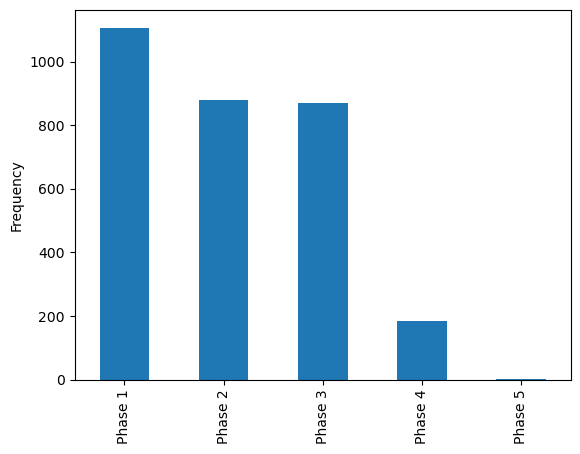

In [3]:
ax = df["fews_ipc"].value_counts().plot(kind="bar")
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)])
ax.set_ylabel('Frequency');

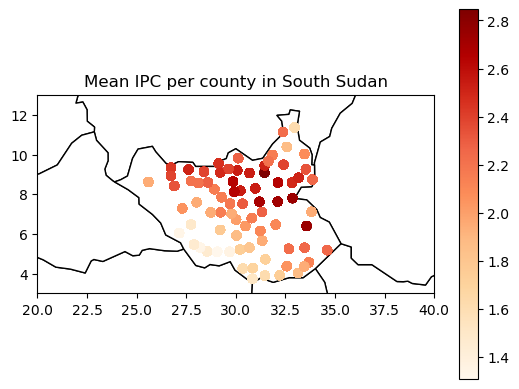

In [4]:
# plot map of south sudan
# first, get map of the world
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# plot world map
ax = world.plot(color="white", edgecolor="black")
# bound to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"]))
mean_ipc = (
    df.reset_index()[["fews_ipc", "admin_name"]]
    .groupby("admin_name")
    .mean()
    .rename(columns={"fews_ipc": "mean_ipc"})
)
gdf.merge(mean_ipc, on="admin_name").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)
ax.set_title("Mean IPC per county in South Sudan");

## Lagging our input variables by 3 months
Feature engineering can of course be extended much further than this.

In [5]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

In [6]:
df = create_lag_df(df, ['acled_count', 'ndvi_anom'], 3, rolling=6)
df = create_lag_df(df, ['p_staple_food'], 3, difference=True, rolling=6)

df = create_lag_df(df, ['fews_ipc'], 1, dropna=True)
df = create_lag_df(df, ['fews_ipc'], 2, dropna=True)
df = create_lag_df(df, ['fews_ipc'], 3, dropna=True)

## Making predictions

To simplify, we treat the IPC prediction problem as regression rather than classification.
E.g., multivariable logistic regression would be more suited.

In [7]:
X = df.iloc[:, -6:]
X = sm.add_constant(X)
y = df["fews_ipc"]

cutoff = pd.to_datetime("2017-01-01")
X_train = X[X.index.get_level_values(0) < cutoff]
X_test = X[X.index.get_level_values(0) >= cutoff]
y_train = y[y.index.get_level_values(0) < cutoff]
y_test = y[y.index.get_level_values(0) >= cutoff]


model = OLS(y_train, X_train, missing="drop")
results = model.fit()
print(results.summary())

# run model on test data
y_pred = results.predict(X_test)
# print mae
print(f"MAE: {(y_pred - y_test).abs().mean().mean():.2f}")

                            OLS Regression Results                            
Dep. Variable:               fews_ipc   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     360.8
Date:                Fri, 09 Jun 2023   Prob (F-statistic):          4.07e-315
Time:                        10:35:28   Log-Likelihood:                -1638.9
No. Observations:                2028   AIC:                             3292.
Df Residuals:                    2021   BIC:                             3331.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2528    

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

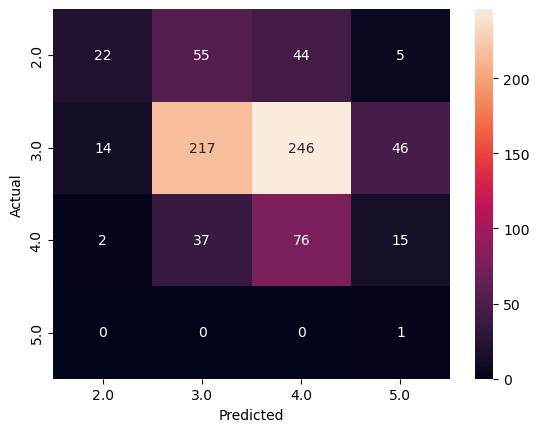

In [8]:
# make confusion matrix
y_pred = y_pred.round()
# cap at 5
y_pred = np.minimum(y_pred, 5)
# cap at 1
y_pred = np.maximum(y_pred, 1)
y_test = y_test.round()
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)

sns.heatmap(confusion_matrix, annot=True, fmt="g")

## Now incorporate news features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [9]:
news_df = pd.read_csv(data_dir + "articles_topics.csv")
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [10]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

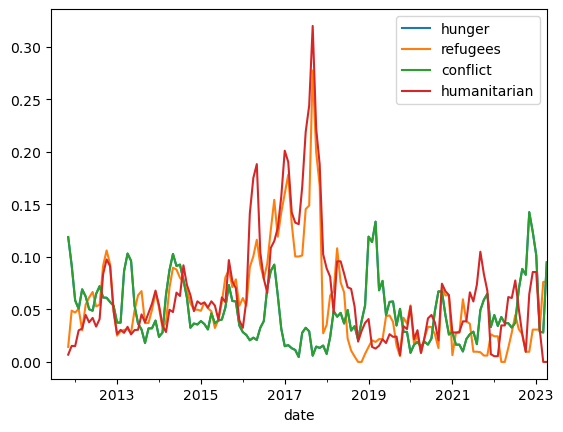

In [11]:
# country wide news features
news_featrues = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

news_featrues.plot();

## Predicting using news features

In [12]:
# change X to include news features
X = df.iloc[:, -6:]
X = X.join(news_featrues, how="left")
X = sm.add_constant(X)

cutoff = pd.to_datetime("2017-01-01")
X_train = X[X.index.get_level_values(0) < cutoff]
X_test = X[X.index.get_level_values(0) >= cutoff]
y_train = y[y.index.get_level_values(0) < cutoff]
y_test = y[y.index.get_level_values(0) >= cutoff]


model = OLS(y_train, X_train, missing="drop")
results = model.fit()
print(results.summary())

# run model on test data
y_pred = results.predict(X_test)
# print mae
print(f"MAE: {(y_pred - y_test).abs().mean().mean():.2f}")

                            OLS Regression Results                            
Dep. Variable:               fews_ipc   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     194.2
Date:                Fri, 09 Jun 2023   Prob (F-statistic):          6.76e-243
Time:                        10:35:29   Log-Likelihood:                -1203.7
No. Observations:                1482   AIC:                             2427.
Df Residuals:                    1472   BIC:                             2480.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.6273    

Our R^2 on the test set has risen somewhat. The performance of this simple strategy only yields modest, but noticible gainns in error on the test set (0.75 vs 0.65)

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

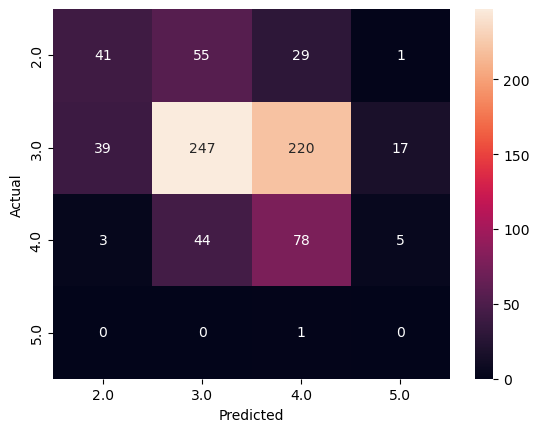

In [13]:
# make confusion matrix
y_pred = y_pred.round()
# cap at 5
y_pred = np.minimum(y_pred, 5)
# cap at 1
y_pred = np.maximum(y_pred, 1)
y_test = y_test.round()
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)

sns.heatmap(confusion_matrix, annot=True, fmt="g")

In [14]:
combined = pd.concat([X, y.rename("ipc")], axis=1)

In [15]:
combined = (
    pd.DataFrame(y.rename("ipc"))
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)

<AxesSubplot: xlabel='ipc', ylabel='Share of total articles'>

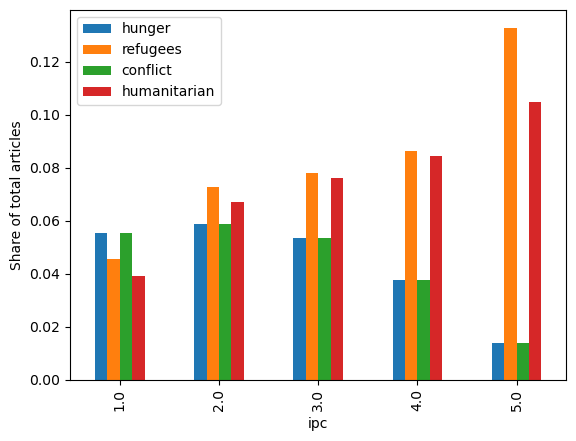

In [16]:
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
)

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [17]:
y_binary_train = y_train > 2
y_binary_train[y_train.isna()] = pd.NA
y_binary_train = y_binary_train.astype("float32")
y_binary_test = y_test > 3
y_binary_test[y_test.isna()] = pd.NA
y_binary_train = y_binary_train.astype("float32")

cols = ['const', 'fews_ipc_lag_1', 'fews_ipc_lag_2', 'fews_ipc_lag_3']

model = sm.Logit(y_binary_train, X_train[cols], missing="drop")
results = model.fit()
print(results.summary())

# run model on test data
y_pred = results.predict(X_test[cols])
# print confusion matrix
y_pred = y_pred.round().astype(bool)
confusion_matrix = pd.crosstab(
    y_binary_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)

Optimization terminated successfully.
         Current function value: 0.318364
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               fews_ipc   No. Observations:                 2028
Model:                          Logit   Df Residuals:                     2024
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:                  0.3487
Time:                        10:35:30   Log-Likelihood:                -645.64
converged:                       True   LL-Null:                       -991.37
Covariance Type:            nonrobust   LLR p-value:                1.487e-149
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.8809      0.307    -22.435      0.000      -7.482      -6.280
fews_ipc_lag_1   

In [18]:
confusion_matrix

Predicted,False,True
Actual,,
False,161,488
True,4,127


the model has many false negatives. Which makes sense given our train/test split. With their only being one large crisis in South Sudan, in 2017.